Accuracy: 1.0

Classification report:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00         3
           H       1.00      1.00      1.00         2

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



C:\Users\torbk\PycharmProjects\PythonProject\Pfootball-prediction\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


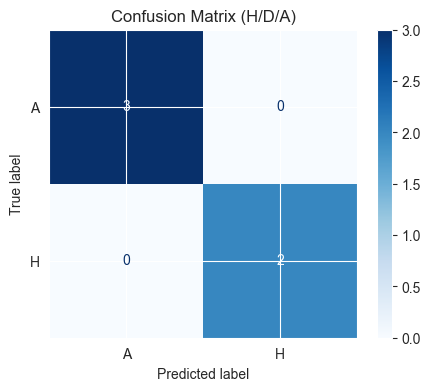


Feature importance per klasse (H/D/A):

   goal_diff  home_avg_goals  away_avg_goals
A  -1.186042       -0.617335        0.568707
D   0.012213        0.167304        0.155092
H   1.173829        0.450031       -0.723799


In [1]:
# 02_first_model.ipynb

# 1) Importer biblioteker
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 2) Les inn data
df = pd.read_csv("../data/matches.csv", parse_dates=["date"])

# 3) Lag target-variabel (H = hjemmeseier, D = uavgjort, A = borteseier)
def match_result(row):
    if row["home_goals"] > row["away_goals"]:
        return "H"
    elif row["home_goals"] < row["away_goals"]:
        return "A"
    else:
        return "D"

df["result"] = df.apply(match_result, axis=1)

# 4) Bygg noen enkle features
# - Målforskjell i kampen
df["goal_diff"] = df["home_goals"] - df["away_goals"]

# - Hjemmelagets snittmål hittil i sesongen
df["home_avg_goals"] = df.groupby("home_team")["home_goals"].expanding().mean().reset_index(level=0, drop=True)
df["away_avg_goals"] = df.groupby("away_team")["away_goals"].expanding().mean().reset_index(level=0, drop=True)

# Fyll NaN (første kamp for laget) med 0
df = df.fillna(0)

# 5) Velg features og target
X = df[["goal_diff", "home_avg_goals", "away_avg_goals"]]
y = df["result"]

# 6) Splitt i trenings- og testsett
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

# 7) Tren en enkel Logistic Regression
model = LogisticRegression(max_iter=500, multi_class="multinomial")
model.fit(X_train, y_train)

# 8) Prediksjon og evaluering
y_pred = model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# 9) Confusion matrix
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax, cmap="Blues")
plt.title("Confusion Matrix (H/D/A)")
plt.show()

# 10) Sjekk koeffisienter (hvilke features betyr mest)
coef_df = pd.DataFrame(model.coef_, columns=X.columns, index=model.classes_)
print("\nFeature importance per klasse (H/D/A):\n")
print(coef_df)
